
📖 [Loading] 处理文件: Qwen2.5-0.5B_result_full_text.jsonl

📖 [Loading] 处理文件: Qwen2.5-1.5B_result_full_text.jsonl
📊 开始对比分析
✅ 使用 pair_id 进行精确对齐
🔗 成功对齐样本数: 2100

🏆 [总体表现]
  • 0.5B Acc: 54.48%
  • 1.5B Acc: 57.95%
  • Delta:      +3.48%

🧩 [显著性分析] McNemar p-value: 1.8409e-04

🔬 [UID 粒度详细分析]

🚀 提升最大的 Top 5 UID:
 phenomenon                       UID  count acc_small acc_large  delta
quantifiers superlative_quantifiers_1    300      8.0%     29.3% +21.3%
    anaphor  anaphor_gender_agreement    300     72.3%     79.7%  +7.3%
quantifiers superlative_quantifiers_2    300     71.3%     76.0%  +4.7%
   ellipsis      ellipsis_n_bar_class    300     85.0%     87.7%  +2.7%
   ellipsis    ellipsis_double_object    300      0.0%      0.0%  +0.0%

📉 倒退最大的 Top 5 UID (Regression):
 phenomenon                       UID  count acc_small acc_large delta
quantifiers superlative_quantifiers_2    300     71.3%     76.0% +4.7%
   ellipsis      ellipsis_n_bar_class    300     85.0%     87.7% +2.7%
   ellipsis    el

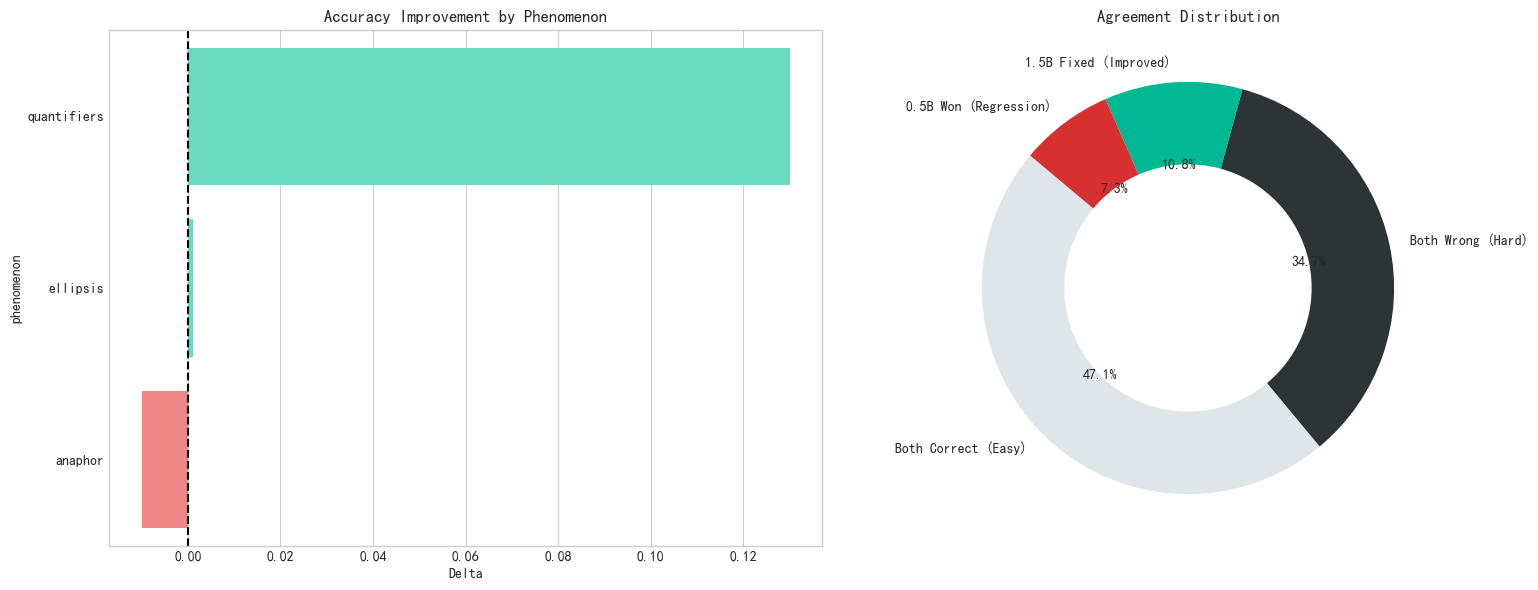


💾 文件保存成功:
  1. analysis_comparison_result.csv (所有样本详情)
  2. analysis_uid_breakdown.csv     (各 UID 准确率统计表)


In [48]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2

# =================配置区域=================
FILE_PATH_05B = 'Qwen2.5-0.5B_result_full_text.jsonl'
FILE_PATH_15B = 'Qwen2.5-1.5B_result_full_text.jsonl'
# ==========================================

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'sans-serif'] 
plt.rcParams['axes.unicode_minus'] = False

def load_results_optimized(filepath):
    print(f"\n📖 [Loading] 处理文件: {filepath}")
    if not os.path.exists(filepath):
        print(f"❌ 错误: 找不到文件 {filepath}")
        return None
    
    try:
        df = pd.read_json(filepath, lines=True)
        if 'is_correct' in df.columns and 'correct' not in df.columns:
            df['correct'] = df['is_correct']
        if 'file_source' not in df.columns:
            df['file_source'] = os.path.basename(filepath)
        df['original_row_index'] = df.index
        return df
    except Exception as e:
        print(f"❌ 读取发生错误: {e}")
        return None

def calculate_mcnemar(matrix_df):
    try:
        b = matrix_df.loc[matrix_df['Category'].str.contains('Fixed'), 'Count'].values[0]
        c = matrix_df.loc[matrix_df['Category'].str.contains('Regression'), 'Count'].values[0]
    except IndexError:
        return 0.0, 1.0
    
    if b + c == 0: return 0.0, 1.0
    statistic = (b - c)**2 / (b + c)
    p_value = 1 - chi2.cdf(statistic, 1)
    return statistic, p_value

def analyze_comparison(df_small, df_large, name_s="0.5B", name_l="1.5B"):
    print("="*40)
    print("📊 开始对比分析")
    print("="*40)

    # 1. 数据对齐
    align_keys = ['file_source', 'phenomenon', 'UID']
    if 'pair_id' in df_small.columns and 'pair_id' in df_large.columns:
        align_keys.append('pair_id')
        print("✅ 使用 pair_id 进行精确对齐")
    else:
        align_keys.append('original_row_index')
        print("⚠️ 未发现 pair_id，使用原始行号 (row_index) 对齐")

    meta_cols = align_keys + ['sentence_good', 'sentence_bad'] 
    existing_meta = [c for c in meta_cols if c in df_small.columns]
    
    df_compare = pd.merge(
        df_small[existing_meta + ['correct']],
        df_large[existing_meta + ['correct']],
        on=existing_meta,
        suffixes=(f'_{name_s}', f'_{name_l}')
    )
    print(f"🔗 成功对齐样本数: {len(df_compare)}")

    # 2. 核心计算
    col_s = f'correct_{name_s}'
    col_l = f'correct_{name_l}'
    
    df_compare['both_correct'] = df_compare[col_s] & df_compare[col_l]
    df_compare['both_wrong'] = (~df_compare[col_s]) & (~df_compare[col_l])
    df_compare['fixed'] = (~df_compare[col_s]) & df_compare[col_l]
    df_compare['regression'] = df_compare[col_s] & (~df_compare[col_l])

    # 3. 总体统计
    acc_s = df_compare[col_s].mean()
    acc_l = df_compare[col_l].mean()
    print(f"\n🏆 [总体表现]")
    print(f"  • {name_s} Acc: {acc_s:.2%}")
    print(f"  • {name_l} Acc: {acc_l:.2%}")
    print(f"  • Delta:      {acc_l - acc_s:+.2%}")

    # 4. McNemar 检验
    matrix_data = [
        {'Category': 'Both Correct (Easy)', 'Count': df_compare['both_correct'].sum()},
        {'Category': 'Both Wrong (Hard)',   'Count': df_compare['both_wrong'].sum()},
        {'Category': f'{name_l} Fixed (Improved)',     'Count': df_compare['fixed'].sum()},
        {'Category': f'{name_s} Won (Regression)',     'Count': df_compare['regression'].sum()}
    ]
    df_matrix = pd.DataFrame(matrix_data)
    stat, p_val = calculate_mcnemar(df_matrix)
    print(f"\n🧩 [显著性分析] McNemar p-value: {p_val:.4e}")

    # 5. Phenomenon 统计
    phenom_group = df_compare.groupby('phenomenon')[[col_s, col_l]].mean()
    phenom_group['Delta'] = phenom_group[col_l] - phenom_group[col_s]
    phenom_group = phenom_group.sort_values('Delta', ascending=False)

    return df_compare, phenom_group, df_matrix

# ================= 新增：UID 详细分析函数 =================
def analyze_uid_stats(df_compare, name_s="0.5B", name_l="1.5B"):
    """
    计算每个 UID 的详细准确率和 Delta
    """
    print(f"\n🔬 [UID 粒度详细分析]")
    col_s = f'correct_{name_s}'
    col_l = f'correct_{name_l}'

    # 按 Phenomenon 和 UID 分组聚合
    uid_stats = df_compare.groupby(['phenomenon', 'UID']).agg(
        count=('file_source', 'count'),       # 样本数量
        acc_small=(col_s, 'mean'),            # 小模型准确率
        acc_large=(col_l, 'mean')             # 大模型准确率
    ).reset_index()

    # 计算差值
    uid_stats['delta'] = uid_stats['acc_large'] - uid_stats['acc_small']

    # 按提升幅度降序排列
    uid_stats = uid_stats.sort_values('delta', ascending=False)

    # 打印 Top 5 提升
    print("\n🚀 提升最大的 Top 5 UID:")
    print(uid_stats.head(5).to_string(index=False, formatters={
        'acc_small': '{:.1%}'.format, 'acc_large': '{:.1%}'.format, 'delta': '{:+.1%}'.format
    }))

    # 打印 Top 5 倒退
    print("\n📉 倒退最大的 Top 5 UID (Regression):")
    print(uid_stats.tail(5).to_string(index=False, formatters={
        'acc_small': '{:.1%}'.format, 'acc_large': '{:.1%}'.format, 'delta': '{:+.1%}'.format
    }))

    return uid_stats

def visualize_results(df_phenom, df_matrix):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Delta Plot
    colors = ['#ff7675' if x < 0 else '#55efc4' for x in df_phenom['Delta']]
    sns.barplot(x=df_phenom['Delta'], y=df_phenom.index, ax=axes[0], hue=df_phenom.index, palette=colors, legend=False)
    axes[0].set_title('Accuracy Improvement by Phenomenon')
    axes[0].axvline(0, color='black', linestyle='--')
    
    # Donut Chart
    axes[1].pie(df_matrix['Count'], labels=df_matrix['Category'], autopct='%1.1f%%', 
                startangle=140, colors=['#dfe6e9', '#2d3436', '#00b894', '#d63031'], 
                wedgeprops=dict(width=0.4))
    axes[1].set_title('Agreement Distribution')
    
    plt.tight_layout()
    plt.show()

# =================执行逻辑=================
if __name__ == "__main__":
    df_05 = load_results_optimized(FILE_PATH_05B)
    df_15 = load_results_optimized(FILE_PATH_15B)

    if df_05 is not None and df_15 is not None:
        # 1. 基础对比
        df_merged, df_phenom_stats, df_consistency = analyze_comparison(df_05, df_15)
        
        # 2. [新增] UID 粒度分析
        df_uid_stats = analyze_uid_stats(df_merged)
        
        # 3. 可视化
        visualize_results(df_phenom_stats, df_consistency)
        
        # 4. 保存文件
        # 保存合并后的原始数据
        df_merged.to_csv('analysis_comparison_result.csv', index=False, encoding='utf-8-sig')
        # 保存 UID 统计表
        df_uid_stats.to_csv('analysis_uid_breakdown.csv', index=False, encoding='utf-8-sig')
        
        print("\n💾 文件保存成功:")
        print("  1. analysis_comparison_result.csv (所有样本详情)")
        print("  2. analysis_uid_breakdown.csv     (各 UID 准确率统计表)")